<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test basic DSP functionalities

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [17]:
from optic.dsp.core import pnorm, signal_power, decimate, resample, lowPassFIR, firFilter, clockSamplingInterp, quantizer, upsample, pulseShape
from optic.utils import parameters
from optic.plot import eyediagram
from optic.comm.modulation import modulateGray
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

In [3]:
%load_ext autoreload
%autoreload 2

## Test rational resample

C:\Users\edson\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 0.1)

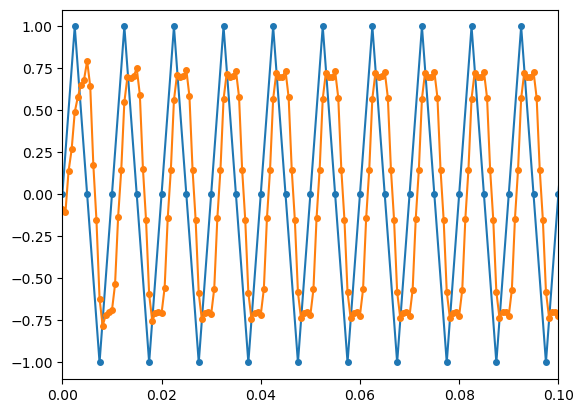

In [4]:
Fs = 400
fc = 100

t = np.arange(0,4096)*(1/Fs)
π = np.pi

sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

paramDec = parameters()
paramDec.SpS_in = 4
paramDec.SpS_out = 16
paramDec.Rs = fc

resFactor = paramDec.SpS_out/paramDec.SpS_in

t_dec = np.arange(0, int(resFactor*4096))*(1/(resFactor*Fs))
sig_dec = resample(sig, paramDec)

plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

## Test sampling clock converter

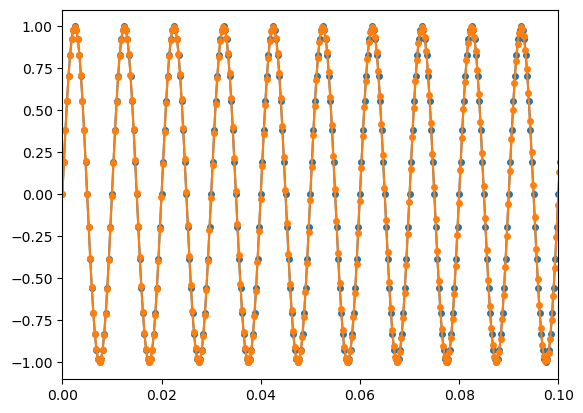

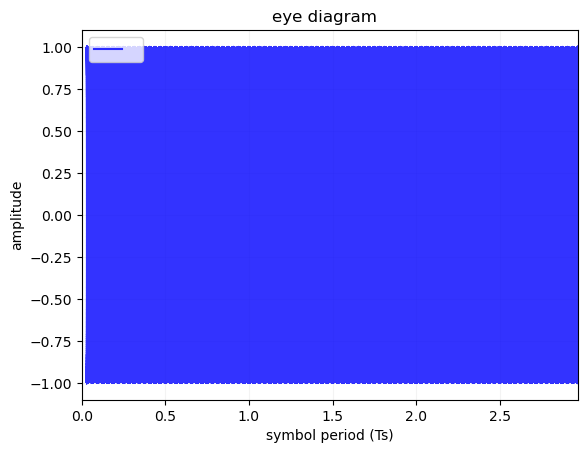

In [5]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# intermpolate signal to a given clock sampling frequency and jitter
Fs_in = Fs
Fs_out = 1.001*Fs
AAF = False
jitter_rms = 1e-9

t_dec = clockSamplingInterp(t.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
sig_dec = clockSamplingInterp(sig.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

eyediagram(sig_dec.reshape(-1,), sig_dec.size, int(Fs//fc), n=3, ptype='fast', plotlabel=None)

## Test signal quantizer

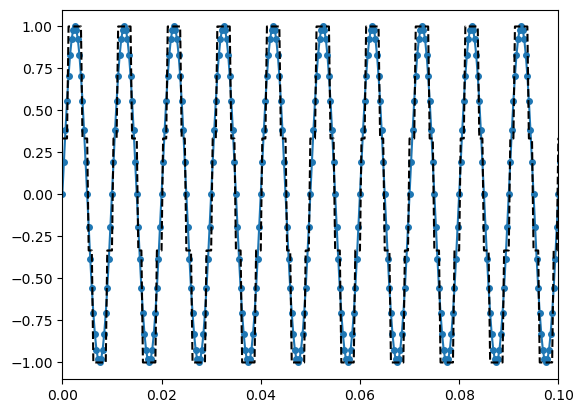

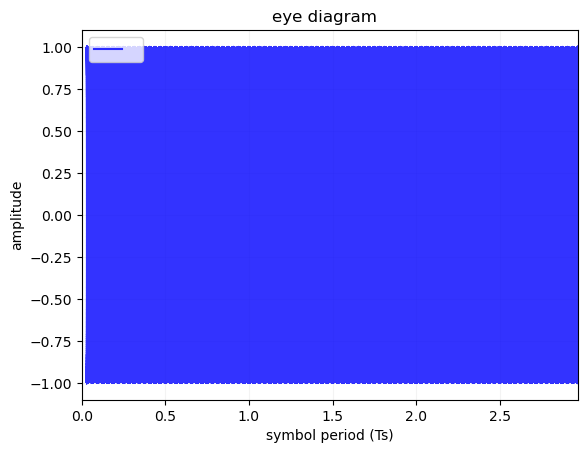

In [6]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t) #+ np.sin(6*π*fc*t)/3 + np.sin(10*π*fc*t)/5

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# quantizer
nBits = 2
sig_q = quantizer(sig.reshape(-1,1), nBits)

plt.plot(t, sig_q,'--k',markersize=4);
plt.xlim(0, 10*1/fc)

eyediagram(sig_dec.reshape(-1,), sig_dec.size, int(Fs//fc), n=3, ptype='fast', plotlabel=None)

In [7]:
def adc(Ei, param):
    """
    Analog-to-digital converter (ADC) model.

    Parameters
    ----------
    Ei : ndarray
        Input signal.
    param : core.parameter
        Resampling parameters:
            param.Fs_in  : sampling frequency of the input signal.
            param.Fs_out : sampling frequency of the output signal.
            param.jitter_rms : root mean square (RMS) value of the jitter in seconds.
            param.nBits : number of bits used for quantization.
            param.Vmax : maximum value for the ADC's full-scale range.
            param.Vmin : minimum value for the ADC's full-scale range.
            param.AAF : flag indicating whether to use anti-aliasing filters (True/False).
            param.N : number of taps of the anti-aliasing filters.

    Returns
    -------
    Eo : ndarray
        Resampled and quantized signal.

    """
    # Check and set default values for input parameters
    param.Fs_in = getattr(param, "Fs_in", 1)
    param.Fs_out = getattr(param, "Fs_out", 1)
    param.jitter_rms = getattr(param, "jitter_rms", 0)
    param.nBits = getattr(param, "nBits", 16)
    param.Vmax = getattr(param, "Vmax", 1)
    param.Vmin = getattr(param, "Vmin", -1)
    param.AAF = getattr(param, "AAF", True)
    param.N   = getattr(param, "N", 202)

    # Extract individual parameters for ease of use
    Fs_in = param.Fs_in
    Fs_out = param.Fs_out
    jitter_rms = param.jitter_rms
    nBits = param.nBits
    Vmax = param.Vmax
    Vmin = param.Vmin
    AAF = param.AAF
    N = param.N

    # Reshape the input signal if needed to handle single-dimensional inputs
    try:
        Ei.shape[1]
    except IndexError:
        Ei = Ei.reshape(len(Ei), 1)

    # Get the number of modes (columns) in the input signal
    nModes = Ei.shape[1]

    # Apply anti-aliasing filters if AAF is enabled
    if AAF:
        # Anti-aliasing filters:
        Ntaps = min(Ei.shape[0], N)
        hi = lowPassFIR(param.Fs_out/2, param.Fs_in, Ntaps, typeF="rect")
        ho = lowPassFIR(param.Fs_in/2, param.Fs_out, Ntaps, typeF="rect")

        Ei = firFilter(hi, Ei)

    # Signal interpolation to the ADC's sampling frequency
    Eo = clockSamplingInterp(Ei, Fs_in, Fs_out, jitter_rms)

    # Uniform quantization of the signal according to the number of bits of the ADC
    Eo = quantizer(Eo, nBits, Vmax, Vmin)

    # Apply anti-aliasing filters to the output if AAF is enabled
    if AAF:
        Eo = firFilter(ho, Eo)

    return Eo

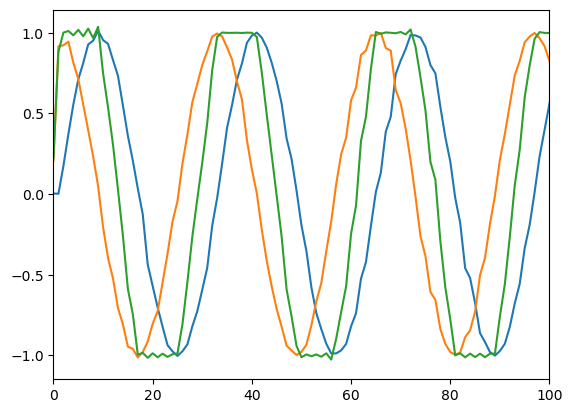

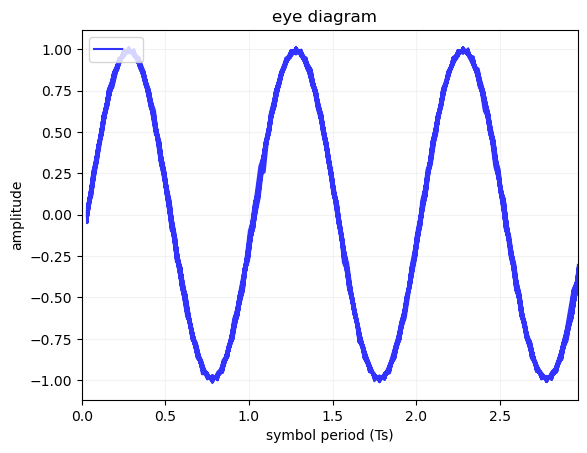

In [8]:
Fs = 3200
fc = 100

t = np.arange(0, 10000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.array([np.sin(2*π*fc*t), np.cos(2*π*fc*t), np.sin(2*π*fc*t)+np.cos(2*π*fc*t)]).T

# ADC input parameters
param = parameters()
param.Fs_in = Fs
param.Fs_out = Fs
param.jitter_rms = 5e-5
param.nBits =  16
param.Vmax = 1
param.Vmin = -1
param.AAF = True
param.N = 512

sig_adc = adc(sig, param)

plt.plot(sig_adc)
plt.xlim(0,100);

eyediagram(sig_adc[:,0], sig_adc.shape[0], int(param.Fs_out//fc), n=3, ptype='fast', plotlabel=None)

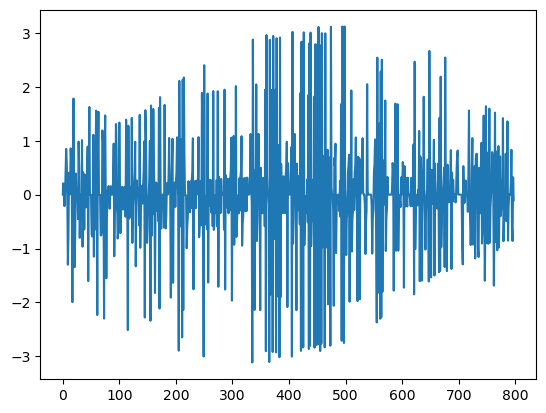

In [32]:
import numpy as np

def gardner_ted(signal):
    ted_values = []
    
    for i in range(1, len(signal) - 1):               
        # Acumulação
        ted = signal[i]*(signal[i+1]-signal[i-1])
        ted_values.append(ted)

    return ted_values

# simulation parameters
SpS = 16            # samples per symbol
M = 4              # order of the modulation format
Rs = 10e9          # Symbol rate (for OOK case Rs = Rb)
Fs = SpS*Rs        # Sampling frequency in samples/second
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*4e2))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)
sigRx = clockSamplingInterp(sigTx.reshape(-1,1), Fs, Fs/8.01, 0)

ted_values = gardner_ted(sigRx)
#print("TED Values:", ted_values)

plt.plot(ted_values)

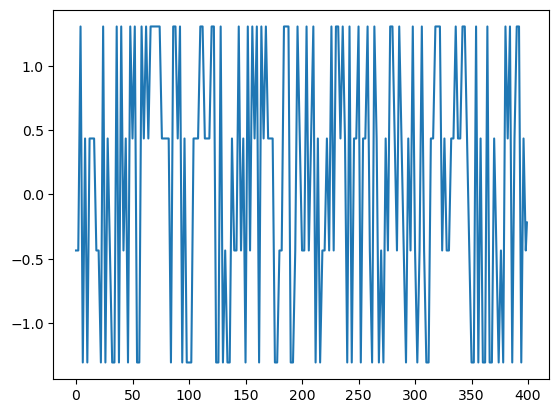

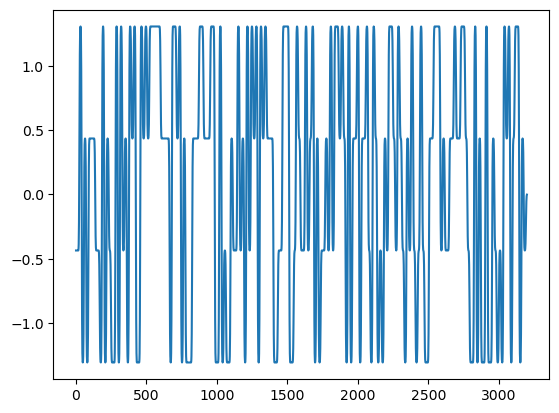

In [25]:
plt.plot(sigRx)
plt.figure()
plt.plot(sigTx)